In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

Dataset can be downloaded from 

https://drive.google.com/drive/folders/1c-QdjiET4uQOgtvwGaL6uCzo3MHXG4PK

In [0]:
import tarfile
my_tar = tarfile.open('drive/My Drive/DL_Assignment_2/face.test.tar.gz')
my_tar.extractall('./') # specify which folder to extract to
my_tar = tarfile.open('drive/My Drive/DL_Assignment_2/face.train.tar.gz')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [0]:
def load_dataset(data_path):
    #data_path = 'data/train/'
    
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)),]),
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1083, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [0]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128, 32)
        self.conv1_dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(out.size(0), -1)
        out = torch.tanh(self.fc1(out))
        out = self.conv1_dropout(out)
        out = self.fc2(out)
        return out

In [6]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (conv1_dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 50

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(load_dataset("./train")):
        correct_train = 0
        total_train = 0
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

            
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(load_dataset("./test")):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

epoch : 1, train loss : 0.5400, valid loss : 0.3297, valid acc : 90.05%
epoch : 2, train loss : 0.2638, valid loss : 0.2458, valid acc : 91.25%
epoch : 3, train loss : 0.1919, valid loss : 0.1541, valid acc : 94.47%
epoch : 4, train loss : 0.1481, valid loss : 0.1444, valid acc : 94.64%
epoch : 5, train loss : 0.1205, valid loss : 0.1377, valid acc : 95.13%
epoch : 6, train loss : 0.0926, valid loss : 0.1360, valid acc : 95.25%
epoch : 7, train loss : 0.0737, valid loss : 0.1065, valid acc : 96.27%
epoch : 8, train loss : 0.0574, valid loss : 0.1065, valid acc : 96.23%
epoch : 9, train loss : 0.0500, valid loss : 0.0840, valid acc : 97.35%
epoch : 10, train loss : 0.0390, valid loss : 0.0812, valid acc : 97.65%
epoch : 11, train loss : 0.0311, valid loss : 0.0801, valid acc : 97.56%
epoch : 12, train loss : 0.0258, valid loss : 0.0785, valid acc : 97.77%
epoch : 13, train loss : 0.0215, valid loss : 0.0828, valid acc : 97.56%
epoch : 14, train loss : 0.0186, valid loss : 0.0785, valid 

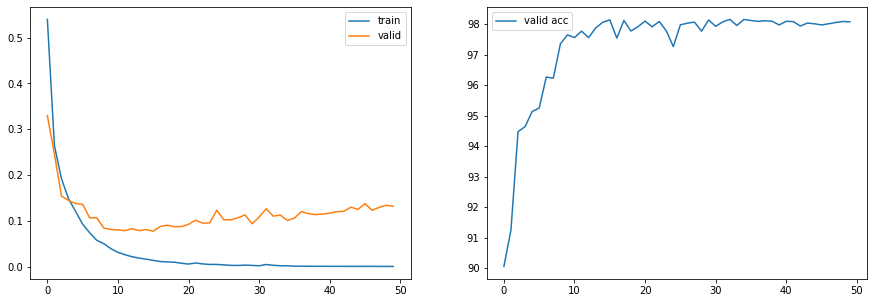

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(load_dataset("./test")):
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    valid_losses.append(loss.item())
            
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
            
accuracy = 100*correct/total
print (accuracy)

98.07860262008734
